## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось


## Важно 2 (0 - 0.15 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы.



## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. 
В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например дополнительные лоссы для стабилизации, WGAN-GP, а не GAN/WGAN+clip)


In [1]:
import numpy as np
import torchvision
import wandb

import torch
from torch import nn
from torch.nn import functional as F

from tqdm.notebook import tqdm
from IPython.display import clear_output


import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
wandb.init(project='StarGAN1.4', reinit=True)

_timestamp,1615841127
_step,12137
G/loss_rec,0.15021
D/loss_gp,0.08514
G/loss_cls,9.98471
fid,113.8307
_runtime,16237
D/loss_real,-5.75502
G/loss_fake,2.18916
D/loss_fake,-2.42012
D/loss_cls,8.12176


D/loss_real,█▆▅▅▇█▆▇▄▇▄▇▆▇▆▆▇█▇▆▆▄▃▄▅▆▅▄▅▄▄▃▄▂▃▃▁▃▂▂
D/loss_fake,▂▃▂▅▂▁▂▃▅▂▅▃▄▃▃▂▁▁▃▃▄▅▆▅▄▄▅▅▄▅▄▆▅▇▇▇█▇▇▇
D/loss_cls,█▇▃▆▅▇▄▂▅▃▂▄▅▃▃▁▄▄▃▄▄▄▄▃▄▃▃▂▂▄▂▄▂▄▂▁▁▂▂▁
D/loss_gp,▅▆▅▄█▆▇▅▃▅▄▂▃▄▃▅▇▆▂▂▂▃▂▄▄▂▂▃▁▂▅▂▂▆▂▄▃▄▄▄
G/loss_fake,▆▆▇▄▆█▇▇▅▇▄▇▆▇▅▇██▆▆▅▅▄▄▅▅▄▅▆▄▅▃▄▂▂▂▁▂▃▃
G/loss_rec,▆▅▆▂▅▃▄▆▅▃▃▃▃▄▃▂▄█▃▅▃▃▃▂▂▅▂▂▃▂▁▂▃▁▃▁▂▂▃▂
G/loss_cls,▅▇▇██▆▅▅▄▃▄▃▃▃▃▃▃▃▂▃▃▂▃▂▂▁▃▂▂▂▂▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
fid,█▆▇▅▂▁▁▂


В этом домашнем задании мы будем работать с Celeba. Celeba - это уже известный вам датасет состоящий из фотографий селеб в их привычной местности:

In [4]:
from torchvision import transforms

INP_SIZE = 64

transforms = transforms.Compose([
#     transforms.RandomRotation((-15, 15)),
#     transforms.RandomHorizontalFlip(p=0.3),
    transforms.CenterCrop(178),
    transforms.Resize((INP_SIZE,INP_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [5]:
BATCH_SIZE = 24
test_size = 100


def target_trans(target):
    res_inds = [4, 8, 9, 20, 31]
    return target[res_inds]

celeba = torchvision.datasets.CelebA('celeba', target_type='attr', transform=transforms, download=True) #, target_transform=target_trans)
celeba_dataloader = torch.utils.data.DataLoader(celeba, BATCH_SIZE, shuffle=True)
index2attr = {i:j for i, j in enumerate(celeba.attr_names)}

my_index2attr = {i:j for i, j in enumerate(['Bald', 'Black_Hair', 'Blond_Hair', 'Male', 'Smiling'])}
# res_inds = []
# for k, v in index2attr.items():
#     if v in my_index2attr.values():
#         res_inds.append(k)


train_size = int(len(celeba_dataloader.dataset) - test_size)
val_size = int(train_size * 0.1)
train_size = int(train_size * 0.9) 
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(celeba, [train_size, test_size, val_size])

dataloader_train = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=6)
dataloader_val = torch.utils.data.DataLoader(val_dataset, BATCH_SIZE, shuffle=True, num_workers=6)
dataloader_test = torch.utils.data.DataLoader(test_dataset, 1, shuffle=False, num_workers=6)

Files already downloaded and verified


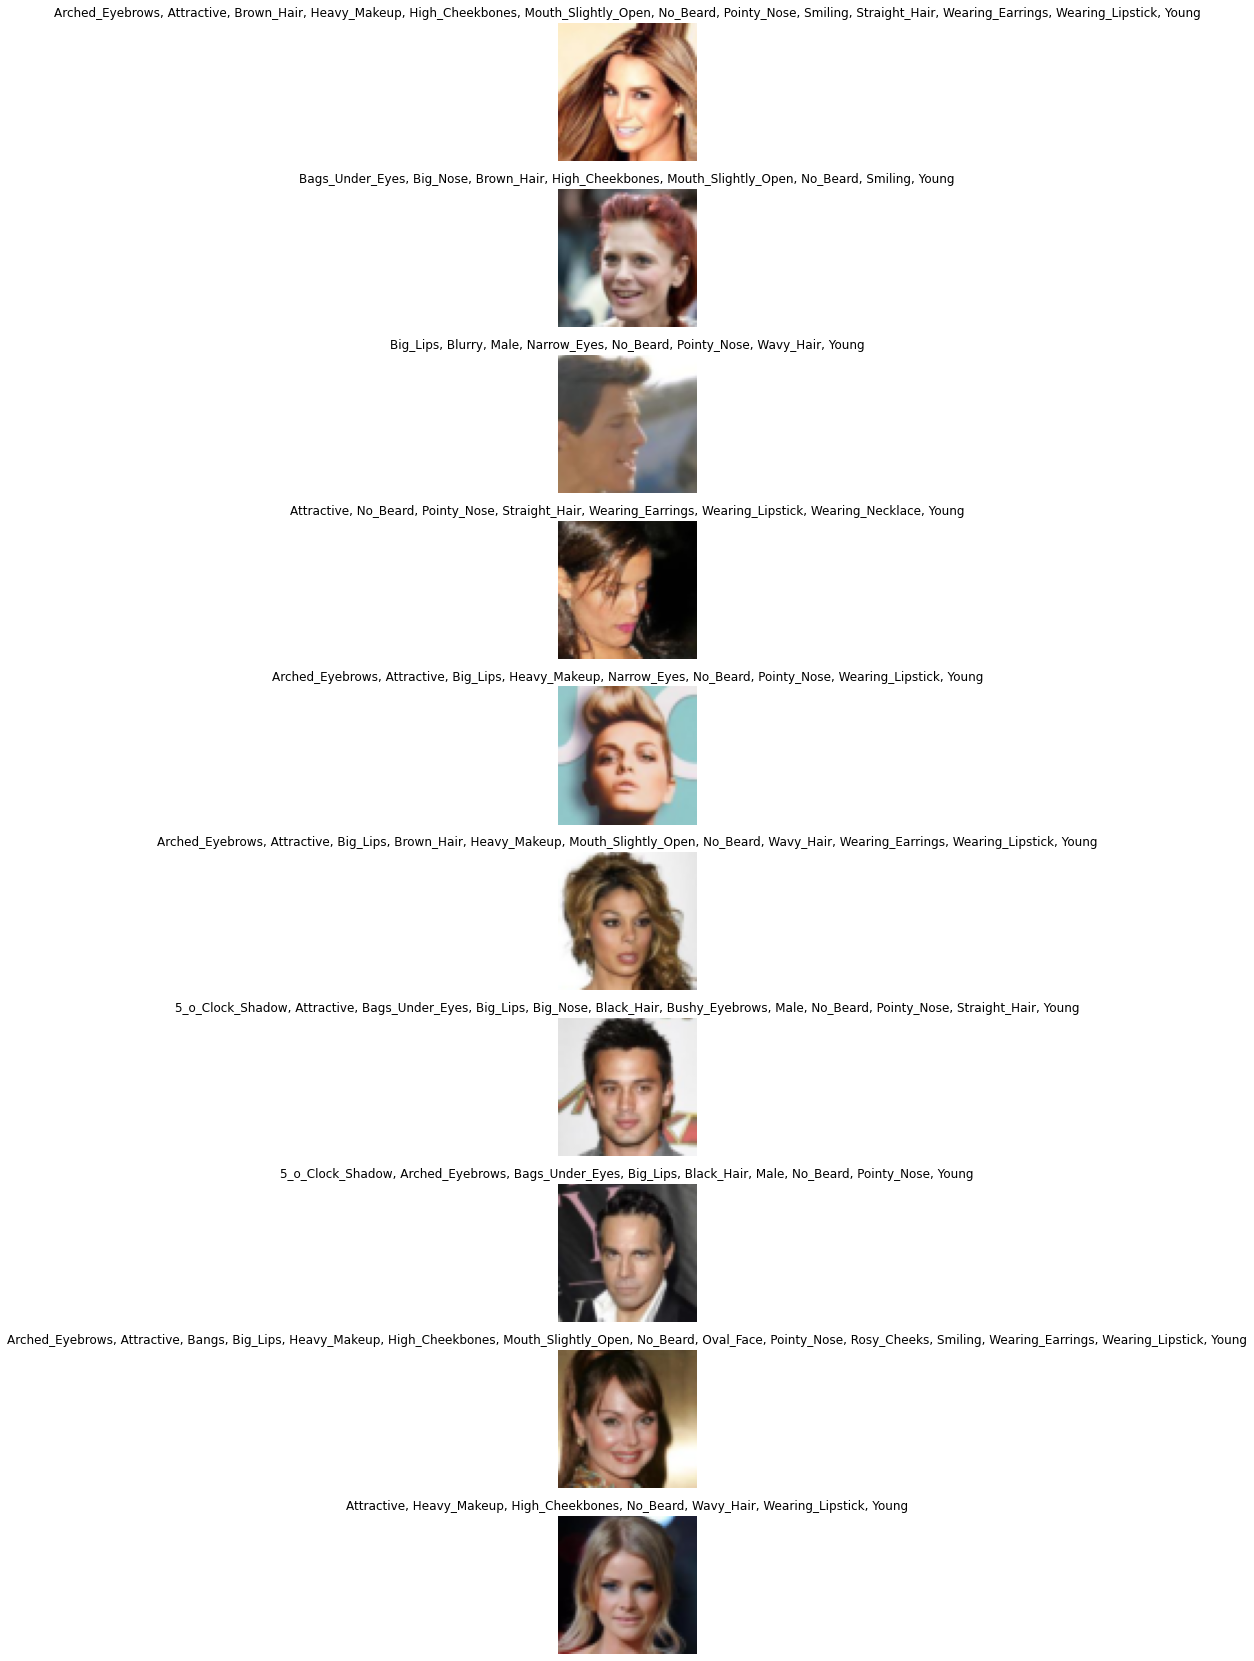

In [6]:
plt.figure(figsize=(30, 30))
for index, (image, attr) in enumerate(celeba):
    if index >= 10: break
    plt.subplot(10, 1, index+1)
    plt.imshow((image.squeeze().permute(1, 2, 0) + 1) / 2)
    plt.title(', '.join([index2attr[att_i] for att_i, att_val in enumerate(attr.view(-1)) if att_val == 1]))
    plt.axis('off')

plt.show()

В этой домашней работе вам предлагается повторить результаты статьи StarGAN (https://arxiv.org/abs/1711.09020). 

Основная часть домашнего задания - чтение статьи и улучшение результатов, поэтому обязательно прочитайте не только StarGAN, но и другие Image-to-Image GAN подходы того времени (17-18 год) 


## Задача 1 (0.4 балла):

Повторить результаты StarGAN используя только CelebA

что это значит: в статье предлагается способ использовать несколько датасетов и выучивание аттрибутов уникальных для какого-то одного датасета. Мы не просим вас это делать, вам достаточно просто обучить StarGAN на CelebA

In [7]:
from model import StarGAN

model = StarGAN(list(index2attr.values()), index2attr, 'on', num_epoch=12, batch_size=BATCH_SIZE,
                _in=INP_SIZE, _out=INP_SIZE, res_blocks_num=5)

In [8]:
model.train(dataloader_train, dataloader_val, dataloader_test, 5)

initialize network with normal
initialize network with normal
Loaded 1th network


/home/pfederov/DL/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Loaded 1th network


Loaded 1th network



Loaded 2th network


Loaded 2th network



Loaded 3th network


Loaded 3th network



Loaded 4th network


Loaded 4th network



Loaded 5th network


Loaded 5th network



Loaded 6th network


Loaded 6th network



Loaded 7th network


Loaded 7th network



Loaded 8th network


Loaded 8th network


KeyboardInterrupt: 

In [7]:
model.test(dataloader_test,12)

Loaded 12th network


## Важно 4: 

Если вы учите на колабе или на наших машинках, вероятнее всего что обучение будет очень долгим на картинках 256х256. Никто не мешает уменьшить разрешение, главное чтобы было видно что трансформации выучились

Еще, кажется что не все аттрибуты селебы являются очень важными или достаточно представленными в датасете. Не запрещается убирать бесполезные аттрибуты (только обоснуйте почему так сделали в отчете)

Не забывайте про аугментации

## Важно 5: 

Да, мы знаем что в на гитхабе лежить готовый код на путорче для этой статьи. Проблема в том что он написал на torch 0.4, поэтому, если мы увидим что вы используете __старый__ код со старыми модулями, то мы:

1. Будем неодобрительно смотреть
2. За наглое списывание будем снимать баллы


## Задача 2 (0.2 балла): 

Мерить качество на глаз - плохая идея. Подключите подсчет FID для каждой N эпохи, чтобы вы могли следить за прогрессом модели.

Сранение моделей между собой тоже возможно только по FID, поэтому трекайте его когда будете делать другие эксперименты

## Задача 3 (0.4 балла):

Если вы будете дословно повторять архитектуру авторов статьи, вы сразу же увидите что обучение станет дико долгим и не очень стабильным. Возможно у вас получится предложить несколько улучшений, которые приведут к хорошему FID, к визуально лучшим результатам или к более стабильному обучению.

В этой задаче хочется чтобы вы попробовали улучшить результаты статьи используя либо то что уже знаете, либо что-то из релевантных статей по Im2Im современности

## Важно 6: 

Когда вы будете показывать визуальные трансформации которые делает ваш StarGAN, хорошей идеей будет сразу же зафиксировать набор картинок (очевидно из валидации) и набор трансформаций на которых вы будете показывать результаты. Например: 10 картинок разных людей на которых вы покажете Male-Female, Beard-noBeard, Old-Young трансформации

## Важно 7 (0.15 балла): 

Выдам дополнительные баллы если у вас получится визуально красивая перекраска волос в разные цвета